In [2]:
# CV of LSE
# varying input basin numbers

import sys, os, glob, pickle, toml, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold,  KFold
from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

sys.path.append('../../MOASMO_support')
from MOASMO_parameter_allbasin_emulator import *

In [3]:
# evaluation functions
# evaluate

def evaluate_cv(cv_results):
    # evaluation
    rmse_test = np.nan * np.zeros(len(cv_results))
    rmse_train = np.nan * np.zeros(len(cv_results))
    cc_test = np.nan * np.zeros(len(cv_results))
    cc_train = np.nan * np.zeros(len(cv_results))
    
    for fold in range(len(cv_results)):
        y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        
        # Evaluate the model using 
        rmse_test[fold] = get_rmse(y_test, y_test_pred)
        rmse_train[fold] = get_rmse(y_train, y_train_pred)
        cc_test[fold] = get_cc(y_test, y_test_pred)
        cc_train[fold] = get_cc(y_train, y_train_pred)
            
    return rmse_test, rmse_train, cc_test, cc_train


def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_cc(d1, d2):
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]




# Load data

In [9]:
# load data function, taken from ~/CTSM_repos/CTSM_calibration/src/MOASMO_support/MOASMO_parameter_allbasin_emulator.py
def load_basin_data():
    infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
    infile_param_info = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/src/parameter/CTSM_CAMELS_SA_param_240202.csv'
    infile_attr_foruse = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/data/camels_attributes_table_TrainModel.csv'
    inpath_moasmo = "/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange"
    path_CTSM_case = f'/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_MOASMO_bigrange'
    iterend = 1 # only read data from iter-0

    outpath = f"{inpath_moasmo}/allbasin_emulator"
    os.makedirs(outpath, exist_ok=True)
    
    # Load data: same for all iterations
    df_basin_info = pd.read_csv(infile_basin_info)
    df_param_info = pd.read_csv(infile_param_info)
    
    file_defa_param = f'{outpath}/camels_627basin_ctsm_defa_param.csv'
    df_param_defa = read_allbasin_defa_params(path_CTSM_case, infile_param_info, file_defa_param, len(df_basin_info))

    file_param_lb = f'{outpath}/camels_627basin_ctsm_all_param_lb.gz'
    file_param_ub = f'{outpath}/camels_627basin_ctsm_all_param_ub.gz'
    df_param_lb, df_param_ub = load_basin_param_bounds(inpath_moasmo, df_param_defa, file_param_lb, file_param_ub, np.arange(len(df_basin_info)), 'emutest')

    file_camels_attribute = f'{outpath}/camels_627basin_attribute.pkl'
    df_att = read_camels_attributes(infile_basin_info, file_camels_attribute, np.arange(len(df_basin_info)))
    
    df_att_foruse = pd.read_csv(infile_attr_foruse)
    useattrs = list(df_att_foruse[df_att_foruse['att_Xie2021'].values]['Attribute_text'].values)
    print("The number of attributes used:", len(useattrs))
    print(useattrs)

    # Load data: outputs from each iteration
    for iter in range(0, iterend):
        file_all_param = f'{outpath}/camels_627basin_ctsm_all_param_iter{iter}.gz'
        file_all_metric = f'{outpath}/camels_627basin_ctsm_all_metric_iter{iter}.gz'
        file_all_basinid = f'{outpath}/camels_627basin_ctsm_all_basinid_iter{iter}.gz'
        
        df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, df_param_defa, df_basin_info, iter, file_all_param, file_all_metric, file_all_basinid, np.arange(len(df_basin_info)), 'emutest')
        
        df_basinid_i['iter'] = iter
        
        if iter == 0:
            df_param = df_param_i
            df_metric = df_metric_i
            df_basinid = df_basinid_i
        else:
            df_param = pd.concat([df_param, df_param_i])
            df_metric = pd.concat([df_metric, df_metric_i])
            df_basinid = pd.concat([df_basinid, df_basinid_i])
    
    df_param.index = np.arange(len(df_param))
    df_metric.index = np.arange(len(df_metric))
    df_basinid.index = np.arange(len(df_basinid))

    index = np.isnan(np.sum(df_metric.values, axis=1))
    df_param = df_param[~index]
    df_metric = df_metric[~index]
    df_basinid = df_basinid[~index]
    
    df_param.index = np.arange(len(df_param))
    df_metric.index = np.arange(len(df_metric))
    df_basinid.index = np.arange(len(df_basinid))
    
    print('Number of nan samples:', np.sum(index))
    print("Number of original parameter sets:", len(index))
    print("Number of final parameter sets:", len(df_param))

    return df_basin_info, df_param_info, df_param_defa, df_param_lb, df_param_ub, df_att, df_att_foruse, df_param, df_metric, df_basinid

In [10]:
df_basin_info, df_param_info, df_param_defa, df_param_lb, df_param_ub, df_att, df_att_foruse, df_param, df_metric, df_basinid = load_basin_data()
print('Number of basins:', len(df_basin_info))
print('Number of all parameters:', len(df_param_info))
print('Number of all attributes:', len(df_att.columns))

File exists: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/allbasin_emulator/camels_627basin_attribute.pkl
The number of attributes used: 27
['mean_elev', 'mean_slope', 'area_gauges2', 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover', 'dom_land_cover_frac', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']
Number of nan samples: 3309
Number of original parameter sets: 250800
Number of final parameter sets: 247491
Number of basins: 627
Number of all parameters: 27
Number of all attributes: 62


In [11]:
# just generate a file for use in other scripts
file = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out/basin_id_forinput.gz'
if not os.path.isfile(file):
    df_basinid.to_csv(file, compression='gzip')

In [12]:
inpath_moasmo = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange'
outpath_all = f'{inpath_moasmo}/LargeSampleEmulator_exps_out'
os.makedirs(outpath_all, exist_ok=True)
numbasin = len(df_basin_info)

In [14]:
num_cpus = 10  # Example: Use 4 CPUs

# create model input / output

In [15]:
# Prepare model input and output
useattrs = list(df_att_foruse[df_att_foruse['att_Xie2021'].values]['Attribute_text'].values)

df_input = df_param.copy()
df_input["hru_id"] = df_basinid["hru_id"]
df_input = df_input.merge(df_att[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs
# print("Input parameters:", list(df_param.columns))
# print("Input attribuets:",  useattrs)

# if there is string attributes in the input, convert them to one-hot encoding
for att in useattrs:
    if df_input[att].dtype == "object":
        print('convert', att, 'to one-hot encoding')
        enc = OneHotEncoder(sparse=False)
        enc.fit(df_input[[att]])
        encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
        print('new columns:', encnames)
        df_enc = pd.DataFrame(enc.transform(df_input[[att]]), columns=encnames)
        df_input = pd.concat([df_input, df_enc], axis=1)
        df_input = df_input.drop([att], axis=1)
        inputnames = [i for i in inputnames if i != att] + encnames


# convert to numpy array for training / testing
# print("Input parameters after adjustment:", list(df_param.columns))
# print("Input attribuets after adjustment:",  useattrs)

x_all = df_input[inputnames].values.copy()
print("Input shape:", x_all.shape)

convert dom_land_cover to one-hot encoding
new columns: ['dom_land_cover_0', 'dom_land_cover_1', 'dom_land_cover_2', 'dom_land_cover_3', 'dom_land_cover_4', 'dom_land_cover_5', 'dom_land_cover_6', 'dom_land_cover_7', 'dom_land_cover_8', 'dom_land_cover_9', 'dom_land_cover_10', 'dom_land_cover_11']
Input shape: (247491, 65)


In [16]:
# use normalized kge as output

df_output = df_metric.copy()
y_all = df_output[["kge"]].values.copy()
y_all = y_all / (2 - y_all) # normalize KGE

print("Output shape:", y_all.shape)

Output shape: (247491, 1)


# Group K-Fold cross validation
Randomly split basins into different folds

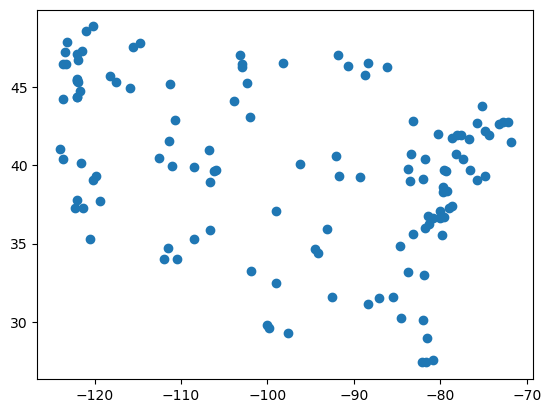

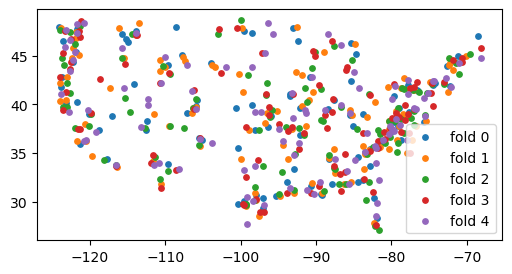

In [65]:
def get_group_cv_indices(df_basinid, nfold=5,  excludeindices=[], rndseed=1234567890):

    random.seed(rndseed)
    np.random.seed(rndseed)

    rawnum = df_basinid['basin_num'].values.copy()
    for i in excludeindices:
        rawnum[rawnum==i] = -1
    rawnum = rawnum[rawnum>=0]
    
    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=nfold)

    # Dictionary to store train and test indices
    group_cv_indices = {}

    # Cross-validation process to save indices
    # does not depend on random seeds
    for fold, (train_index, test_index) in enumerate(group_kfold.split(rawnum, groups=rawnum)):

        # train_index, test_index = rawnum[train_index], rawnum[test_index]
        train_basin = np.unique(rawnum[train_index])
        test_basin = np.unique(rawnum[test_index])

        train_index = df_basinid[df_basinid['basin_num'].isin(train_basin)].index.values
        test_index = df_basinid[df_basinid['basin_num'].isin(test_basin)].index.values

        group_cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_basin': train_basin, 'test_basin': test_basin} 
    return group_cv_indices

rndseed=1234567890
random.seed(rndseed)
np.random.seed(rndseed)
excluderatio = 0.2
sample_size = int(excluderatio * len(df_basin_info)) 
excludeindices = np.random.choice(len(df_basin_info), sample_size, replace=False) 
# print('exclude', excludeindices)
plt.scatter(df_basin_info['lon_cen'].values[excludeindices], df_basin_info['lat_cen'].values[excludeindices])
plt.show()

# Get the indices
nfold = 5
group_cv_indices = get_group_cv_indices(df_basinid, nfold, excludeindices)

# plot test basin batches
fig = plt.figure(figsize=(6, 3))
for fold in range(len(group_cv_indices)):
    test_basin = group_cv_indices[fold]['test_basin']
    lat = df_basin_info.iloc[test_basin]['lat_cen'].values
    lon = df_basin_info.iloc[test_basin]['lon_cen'].values
    plt.scatter(lon, lat, 15, label=f'fold {fold}')

plt.legend()
plt.show()

## Random Forest

In [66]:
# train the model
def rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, modelconfig={'n_estimators': 100, 'random_state': 42}):

    if True:

        rf_cv_results = {}
        
        # Cross-validation loop
        for fold, indices in cv_indices.items():
        
            # print(f"RF Fold {fold}")
        
            train_index = indices['train_index']
            test_index = indices['test_index']
            
            x_train, x_test = x_all[train_index], x_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            
            # Initialize a new RandomForestRegressor for each fold
            rf_model = RandomForestRegressor(**modelconfig, n_jobs=ncpus)
            
            # Train the model
            rf_model.fit(x_train, y_train)
        
            # Predict on the test set
            y_test_pred = rf_model.predict(x_test)
            y_train_pred = rf_model.predict(x_train)

            if y_test_pred.ndim == 1 and y_test.ndim == 2:
                y_test_pred = y_test_pred[:, np.newaxis]
                y_train_pred = y_train_pred[:, np.newaxis]
            
            
            # Store results
            rf_cv_results[fold] = {
                # 'model': rf_model,
                'train_index': train_index,
                'test_index': test_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_test_pred': y_test_pred,
                'y_train_pred': y_train_pred,
            }
        
    return rf_cv_results


In [67]:
outfile = f'{outpath_all}/LSE_RF_normKGE_groupCV_estimates_exclude{excluderatio}.pkl.npz'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        rf_group_cv_results = pickle.load(file)    
else:
    modelconfig = {'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
    rf_group_cv_results = rf_run_cross_validation_parallel(group_cv_indices, x_all, y_all, num_cpus, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(rf_group_cv_results, file)

In [68]:
outfile = f'{outpath_all}/LSE_RF_normKGE_groupCV_evaluation_exclude{excluderatio}.pkl.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    rf_group_rmse_train = dtmp['rf_group_rmse_train']
    rf_group_rmse_test = dtmp['rf_group_rmse_test']
    rf_group_cc_train = dtmp['rf_group_cc_train']
    rf_group_cc_test = dtmp['rf_group_cc_test']

else:
    rf_group_rmse_test, rf_group_rmse_train, rf_group_cc_test, rf_group_cc_train = evaluate_cv(rf_group_cv_results)
    np.savez_compressed(outfile, rf_group_rmse_train=rf_group_rmse_train, rf_group_rmse_test=rf_group_rmse_test, rf_group_cc_train=rf_group_cc_train, rf_group_cc_test=rf_group_cc_test)

print(np.mean(rf_group_rmse_test), np.mean(rf_group_rmse_train), np.mean(rf_group_cc_test), np.mean(rf_group_cc_train))

0.22633669886621707 0.029792347019850625 0.6408147247274264 0.9949070262015969


In [69]:
for i in [0.1, 0.2, 0.3, 0.4, 0.5]:
    outfile = f'{outpath_all}/LSE_RF_normKGE_groupCV_evaluation_exclude{i}.pkl.npz'
    
    if os.path.isfile(outfile):
        dtmp = np.load(outfile)
        rf_group_rmse_train = dtmp['rf_group_rmse_train']
        rf_group_rmse_test = dtmp['rf_group_rmse_test']
        rf_group_cc_train = dtmp['rf_group_cc_train']
        rf_group_cc_test = dtmp['rf_group_cc_test']
    
    print(np.mean(rf_group_rmse_test), np.mean(rf_group_rmse_train), np.mean(rf_group_cc_test), np.mean(rf_group_cc_train))

0.22753413872106082 0.02948312004512859 0.635665865683259 0.9950538114476128
0.22633669886621707 0.029792347019850625 0.6408147247274264 0.9949070262015969
0.23292432850734843 0.029817136914191227 0.618936034613369 0.9948988552324792
0.23991183652181397 0.029536783597792698 0.6090120306844999 0.9950294841891878
0.2589897611941785 0.03004666285440164 0.5298384061528618 0.9948484100712971
